Training span : 1913-01-31 → 1991-08-31  (944 rows)
Testing span  : 1991-09-30 → 2025-05-31  (405 rows)

=== Logistic Regression (balanced) ===
              precision    recall  f1-score   support

           0      0.997     0.929     0.961       322
           1      0.781     0.988     0.872        83

    accuracy                          0.941       405
   macro avg      0.889     0.958     0.917       405
weighted avg      0.952     0.941     0.943       405

Confusion Matrix:
 [[299  23]
 [  1  82]]
ROC AUC: 0.997


C:\Users\ghkjs\anaconda3\envs\econ_trend\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


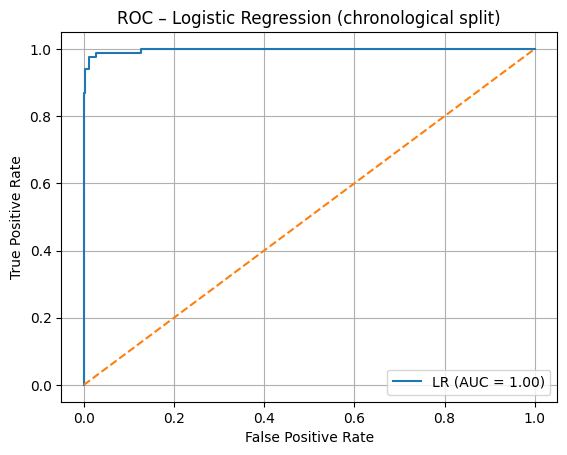

C:\Users\ghkjs\anaconda3\envs\econ_trend\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



=== KNN (k=5) ===
              precision    recall  f1-score   support

           0      0.977     0.907     0.940       322
           1      0.717     0.916     0.804        83

    accuracy                          0.909       405
   macro avg      0.847     0.911     0.872       405
weighted avg      0.923     0.909     0.913       405

Confusion Matrix:
 [[292  30]
 [  7  76]]
ROC AUC: 0.956


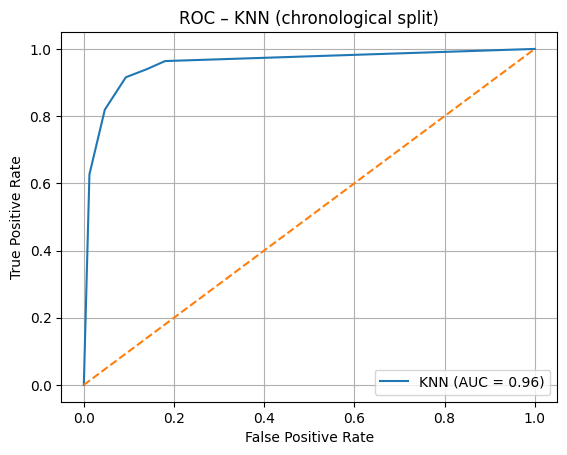


Best F1 = 0.964 at threshold = 0.714


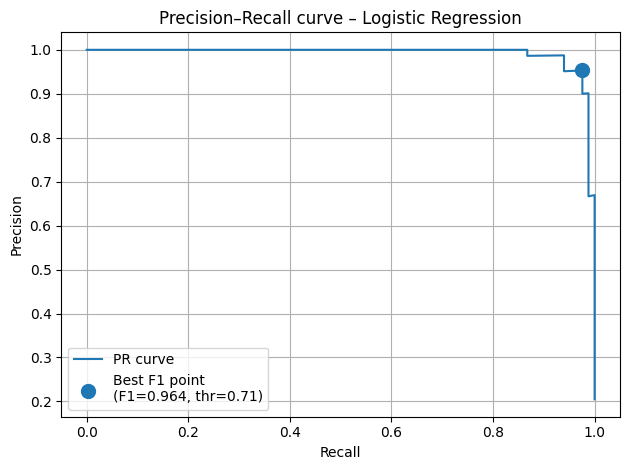


=== Logistic Regression @ optimal PR threshold ===
              precision    recall  f1-score   support

           0      0.994     0.988     0.991       322
           1      0.953     0.976     0.964        83

    accuracy                          0.985       405
   macro avg      0.973     0.982     0.977       405
weighted avg      0.985     0.985     0.985       405

Confusion Matrix:
 [[318   4]
 [  2  81]]


In [1]:
"""
Regime-change classifier (inflation): time-aware pipeline
--------------------------------------------------------

Improvements vs. previous version
---------------------------------
1. **Time-series split** (no shuffling) to give a genuine out-of-sample test.
2. **IterativeImputer** (BayesianRidge) so each missing cell is inferred from
   the joint distribution of the *training* data only.
3. **Balanced class weights** for Logistic Regression to ease minority-class bias.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  # noqa: F401, needed to turn on the feature
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score,
                             roc_curve)

# ------------------------------------------------------------------
# 1. Load & sort
# ------------------------------------------------------------------
df = pd.read_csv(
    r"C:\Users\ghkjs\GitHub\regime-shift-classification\data\processed\inflation_regime_dataset.csv",
    index_col=0,
    parse_dates=True
).sort_index()

# ------------------------------------------------------------------
# 2. Features / target
# ------------------------------------------------------------------
X = df.drop(columns=["Inflation_Regime"])
y = df["Inflation_Regime"]

# ------------------------------------------------------------------
# 3. Chronological train / test split (70 % / 30 %)
# ------------------------------------------------------------------
split_idx = int(len(df) * 0.70)
train_idx = df.index[:split_idx]
test_idx  = df.index[split_idx:]

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]

print(f"Training span : {train_idx.min().date()} → {train_idx.max().date()}  "
      f"({len(train_idx)} rows)")
print(f"Testing span  : {test_idx.min().date()} → {test_idx.max().date()}  "
      f"({len(test_idx)} rows)\n")

# ------------------------------------------------------------------
# 4. Shared preprocessing steps
# ------------------------------------------------------------------
imputer = IterativeImputer(
    random_state=42,
    max_iter=10,                # default 10; tweak if convergence is slow
    initial_strategy="median"   # robust starting guess
)
scaler = StandardScaler()

# ------------------------------------------------------------------
# 5. Logistic Regression pipeline (balanced)
# ------------------------------------------------------------------
lr_pipeline = Pipeline([
    ("imputer",  imputer),
    ("scaler",   scaler),
    ("clf",      LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=42,
    ))
])

lr_pipeline.fit(X_train, y_train)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]
y_pred_lr = (y_prob_lr >= 0.5).astype(int)     # default threshold

print("=== Logistic Regression (balanced) ===")
print(classification_report(y_test, y_pred_lr, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr).round(3))

fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure()
plt.plot(fpr, tpr, label=f"LR (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})")
plt.plot([0, 1], [0, 1], "--")
plt.title("ROC – Logistic Regression (chronological split)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()

# ------------------------------------------------------------------
# 6. K-Nearest Neighbors pipeline (same imputer / scaler)
# ------------------------------------------------------------------
knn_pipeline = Pipeline([
    ("imputer",  imputer),
    ("scaler",   scaler),
    ("clf",      KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)
y_prob_knn = knn_pipeline.predict_proba(X_test)[:, 1]
y_pred_knn = (y_prob_knn >= 0.5).astype(int)

print("\n=== KNN (k=5) ===")
print(classification_report(y_test, y_pred_knn, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("ROC AUC:", roc_auc_score(y_test, y_prob_knn).round(3))

fpr2, tpr2, _ = roc_curve(y_test, y_prob_knn)
plt.figure()
plt.plot(fpr2, tpr2, label=f"KNN (AUC = {roc_auc_score(y_test, y_prob_knn):.2f})")
plt.plot([0, 1], [0, 1], "--")
plt.title("ROC – KNN (chronological split)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()

# ------------------------------------------------------------------
# 7. Precision–Recall curve & optimal threshold
# ------------------------------------------------------------------
from sklearn.metrics import precision_recall_curve, f1_score

# 7-a. Compute precision, recall, thresholds
prec, rec, thr = precision_recall_curve(y_test, y_prob_lr)

# 7-b. F1 for every threshold (skip last element: it’s ‘inf’)
f1_scores = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1])
best_idx   = np.argmax(f1_scores)
best_thr   = thr[best_idx]
best_f1    = f1_scores[best_idx]

print(f"\nBest F1 = {best_f1:.3f} at threshold = {best_thr:.3f}")

# 7-c. Plot
plt.figure()
plt.plot(rec, prec, label="PR curve")
plt.scatter(rec[best_idx], prec[best_idx],
            marker="o", s=100,
            label=f"Best F1 point\n(F1={best_f1:.3f}, thr={best_thr:.2f})")
plt.title("Precision–Recall curve – Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.tight_layout()

# OPTIONAL: save the plot
plt.savefig(r"C:\Users\ghkjs\GitHub\regime-shift-classification\results\pr_curve_lr.png",
            dpi=300)
plt.show()

# 7-d. Apply the new threshold & re-evaluate
y_pred_lr_opt = (y_prob_lr >= best_thr).astype(int)
print("\n=== Logistic Regression @ optimal PR threshold ===")
print(classification_report(y_test, y_pred_lr_opt, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr_opt))